# Spatial Interpolation of WQ data

This document includes Python codes that conduct spatial interpolation for water quality data.

If you are running the code in ArcGIS Notebook, you'll need to install the following packages:

`conda install -c anaconda pandas scikit-learn
conda install -c conda-forge geopandas rasterio contextily
`

**Note: installation of geopandas may take a few hours**

All date are shared in the [box folder](https://usf.box.com/s/xu3dw4i1emv2hzveyf9idnx9q78t939c)

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio as rio
import rasterio.mask
import rasterio.plot as rio_pl
import matplotlib.image as mpimg
import time
#import rioxarray as rxr

from rasterio.plot import show
from rasterio.transform import Affine
from rasterio.mask import mask
from rasterio import MemoryFile
from rasterio.profiles import DefaultGTiffProfile
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import box
from shapely.geometry import Polygon, Point
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
import contextily as cx
#from osgeo import gdal
#from pykrige.ok import OrdinaryKriging

# import arcpy and environmental settings
import arcpy
from arcpy.sa import *
arcpy.env.overwriteOutput = True

# 1. Load Discrete Data and Continuous Data

In [4]:
# path = "E:/Projects/SEACAR_WQ_Pilot/"
# gis_path = path+'GIS_data/'

path = "D:/Water_Quailty/"
gis_path = path+'GIS_data/'

In [5]:
dfDis_orig = pd.read_csv(path + r"OEAT_Discrete-2023-Jan-23.csv")
dfCon1_orig = pd.read_csv(path + r"OEAT_Continuous_1-2023-Jan-23.csv")
dfCon2_orig = pd.read_csv(path + r"OEAT_Continuous_2-2023-Jan-23.csv")

C:\arcpyenv\arcpygeo\lib\site-packages\IPython\core\interactiveshell.py:3552: DtypeWarning: Columns (6,17,18,19,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# 2 Preprocess Data
Preset function parameters

In [32]:
col_ls = ['RowID','ParameterName','ParameterUnits','ProgramLocationID','ActivityType','ManagedAreaName',
                   'SampleDate','Year','Month','ResultValue','ValueQualifier','Latitude_DD','Longitude_DD']
para_ls = ["Salinity","Total Nitrogen","Dissolved Oxygen","Turbidity","Secchi Depth"]

dictArea    = {'Gasparilla Sound-Charlotte Harbor Aquatic Preserve':'Charlotte Harbor','Big Bend Seagrasses Aquatic Preserve':'Big Bend',
                'Guana Tolomato Matanzas National Estuarine Research Reserve':'GTM Reserve','Estero Bay Aquatic Preserve':'Estero Bay',
                'Biscayne Bay Aquatic Preserve':'Biscayne Bay','Matlacha Pass Aquatic Preserve':'Matlacha Pass AP',
                'Lemon Bay Aquatic Preserve':'Lemon Bay','Cape Haze Aquatic Preserve':'Cape Haze AP','Pine Island Sound Aquatic Preserve':'Pine Island'}
dictUnits   = {"Salinity":"ppt","Total Nitrogen": "mg/L","Dissolved Oxygen": "mg/L","Turbidity": "NTU", "Secchi Depth": "m"}
listArea    = dfCon1_orig["ManagedAreaName"].unique()
listPara    = ["Salinity","Total Nitrogen","Dissolved Oxygen","Turbidity","Secchi Depth"] 
drySeason   = [11,12,1,2,3,4]
wetSeason = [5,6,7,8,9,10]


Area = 'Gasparilla Sound-Charlotte Harbor Aquatic Preserve'
Para = 'Dissolved Oxygen'
SpatialRef = '3086'
dry_start,dry_end = '11/01/2016','04/30/2017'
wet_start,wet_end = '05/01/2017','10/31/2017'

Function to preprocess dataframes

In [33]:
def preprocessDis(df,col_ls,para_ls):
    
    # ------- Select columns and parameters ------
    df = df[col_ls]
    df = df.loc[df["ParameterName"].isin(para_ls)]
    df["timestamp"]=  pd.to_datetime(df['SampleDate'])
    #---------- remove outliers -----------------
    # Remove total nitrogen outliers (>100)
    df.drop(df[(df['ParameterName'] == 'Total Nitrogen') & 
                     (df['ResultValue'] > 10)].index,inplace=True)

    # Remove a single measurement in 1996-07-22 (RowID: 1582917)
    df.drop(df[df['RowID'] == 1582917].index, inplace=True)

    # Remove turbidity outliers (>25)
    df.drop(df[(df['ParameterName'] == 'Turbidity') & 
                     (df['ResultValue'] > 25)].index, inplace=True)

    # Remove Secchi Depth before 1995 (117 records)
    df.drop(df[(df['ParameterName'] == 'Secchi Depth') & 
                     (df['Year'] < 1995)].index, inplace=True)
    
    return df

def preprocessCon(df,col_ls,para_ls):
    
    # ------- Select columns and parameters ------
    df = df[col_ls]
    df = df.loc[df["ParameterName"].isin(para_ls)]
    df["timestamp"]=  pd.to_datetime(df['SampleDate'])
    # ------- Select data during daytime ------
    df["Hour"]     = df.apply(lambda x:x["timestamp"].strftime("%H"), axis=1)
    df["Hour"]     = df["Hour"].astype(int)
    df             = df[(df["Hour"]>=8) & (df["Hour"]<=18)]
    #---------- remove outliers -----------------
    # Remove total nitrogen outliers (>100)
    df.drop(df[(df['ParameterName'] == 'Total Nitrogen') & 
                     (df['ResultValue'] > 10)].index,inplace=True)

    # Remove a single measurement in 1996-07-22 (RowID: 1582917)
    df.drop(df[df['RowID'] == 1582917].index, inplace=True)

    # Remove turbidity outliers (>25)
    df.drop(df[(df['ParameterName'] == 'Turbidity') & 
                     (df['ResultValue'] > 25)].index, inplace=True)

    # Remove Secchi Depth before 1995 (117 records)
    df.drop(df[(df['ParameterName'] == 'Secchi Depth') & 
                     (df['Year'] < 1995)].index, inplace=True)
    
    return df

Preprocess dataframes

In [34]:
dfCon1 = preprocessCon(dfCon1_orig, col_ls, para_ls)
dfCon2 = preprocessCon(dfCon2_orig, col_ls, para_ls)
dfDis  = preprocessDis(dfDis_orig, col_ls, para_ls)
dfCon  = pd.concat([dfCon1,dfCon2],ignore_index=True)

# 2. Combine Dis Data and Con Data

Combine dataframes

In [35]:
def combine_dis_con(df_dis,df_con, area, parameter, start, end):
    
    # Select discrete data in time frame and managed areas
    df_dis = df_dis[(df_dis["ParameterName"]==Para)&(df_dis["ManagedAreaName"]==Area)]
    df_dis = df_dis[(df_dis['timestamp'] > start)&(df_dis['timestamp'] < end)]
    df_dis_mean = df_dis.groupby(['Latitude_DD','Longitude_DD',"ParameterName","ManagedAreaName"])["ResultValue"].agg("mean").reset_index()

    # Select wet season data in time frame and managed areas
    df_con = df_con[(df_con["ParameterName"]==Para)&(df_con["ManagedAreaName"]==Area)]
    df_con = df_con[(df_con['timestamp'] > start)&(df_con['timestamp'] < end)]
    df_con_mean = df_con.groupby(['Latitude_DD','Longitude_DD',"ParameterName","ManagedAreaName"])["ResultValue"].agg("mean").reset_index()
   
    # Concatenate dry and wet dataframes
    df_mean = pd.concat([df_dis_mean,df_con_mean],ignore_index=True)
    gdf = gpd.GeoDataFrame(df_mean, geometry = gpd.points_from_xy(df_mean.Longitude_DD, df_mean.Latitude_DD), crs="EPSG:4326")
    
    return df_mean, gdf

In [36]:
dfDryMean, gdfDry = combine_dis_con(dfDis,dfCon,Area,Para,dry_start,dry_end)
dfWetMean, gdfWet = combine_dis_con(dfDis,dfCon,Area,Para,wet_start,wet_end)

gdfDry.to_crs(int(SpatialRef)).to_file(gis_path+'gdfDry.shp', driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
gdfWet.to_crs(int(SpatialRef)).to_file(gis_path+'gdfWet.shp', driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

C:\arcpyenv\arcpygeo\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  after removing the cwd from sys.path.
C:\arcpyenv\arcpygeo\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  """


## Read Managed Areas

In [38]:
MA = gpd.read_file(r"D:\Water_Quailty\ManagedAreas\ORCP_Managed_Areas_Oct2021.shp")
CH = MA[MA['MA_Name']=='Gasparilla Sound-Charlotte Harbor'].to_crs(int(SpatialRef))
CH.to_file(gis_path+ 'ch.shp', driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

## Load Data

Also convert all shapefile to Florida GDL Albers (https://epsg.io/3086)

In [39]:
gdfDryShp = gpd.read_file(gis_path+"gdfDry.shp")
gdfWetShp = gpd.read_file(gis_path+"gdfWet.shp")
extentShp = gpd.read_file(gis_path+"ch.shp")

<AxesSubplot:>

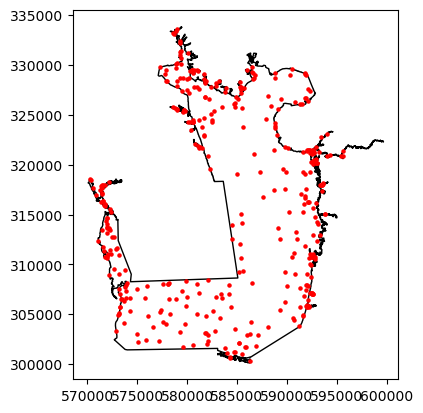

In [40]:
fig, ax = plt.subplots()
extentShp.plot(ax = ax, color='white', edgecolor='black')
gdfWetShp.plot(ax = ax, marker='o', color='red', markersize=5)

In [41]:
extent = str(extentShp.geometry.total_bounds).replace('[','').replace(']','')

# Ordinary Kriging

Run Oridinary Kriging for dry season data

In [42]:
search_radius = 20000
with arcpy.EnvManager(extent = extent, mask = path+"GIS_data/ch.shp",outputCoordinateSystem = arcpy.SpatialReference(3086), cellSize = 30):
    out_surface_raster = arcpy.sa.Kriging(in_point_features = gis_path+"gdfDry.shp",
                                          z_field = "ResultValu",
                                          kriging_model = KrigingModelOrdinary("Spherical # # # #"),
                                         search_radius = RadiusVariable(20, search_radius))
                                                                               
#                                          "Spherical 0.000486 # # #",
#                                          0.000764192085967863,
#                                          "VARIABLE 12",
                                           
    out_surface_raster.save(gis_path+"dryKriging.tif")

Run Ordinary Kriging for wet season data

In [43]:
with arcpy.EnvManager(extent = extent, mask = path+"GIS_data/ch.shp",outputCoordinateSystem = arcpy.SpatialReference(3086), cellSize = 30):
    out_surface_raster = arcpy.sa.Kriging(gis_path+"gdfWet",
                                          "ResultValu",
                                         kriging_model = KrigingModelOrdinary("Spherical # # # #"),
                                         search_radius = RadiusVariable(20, search_radius))
#                                           "Spherical 0.000486 # # #",
#                                           0.000764192085967863,
#                                          "VARIABLE 12",
                                          
    out_surface_raster.save(gis_path+"wetKriging2.tif")

### Visualize interpolated rasters

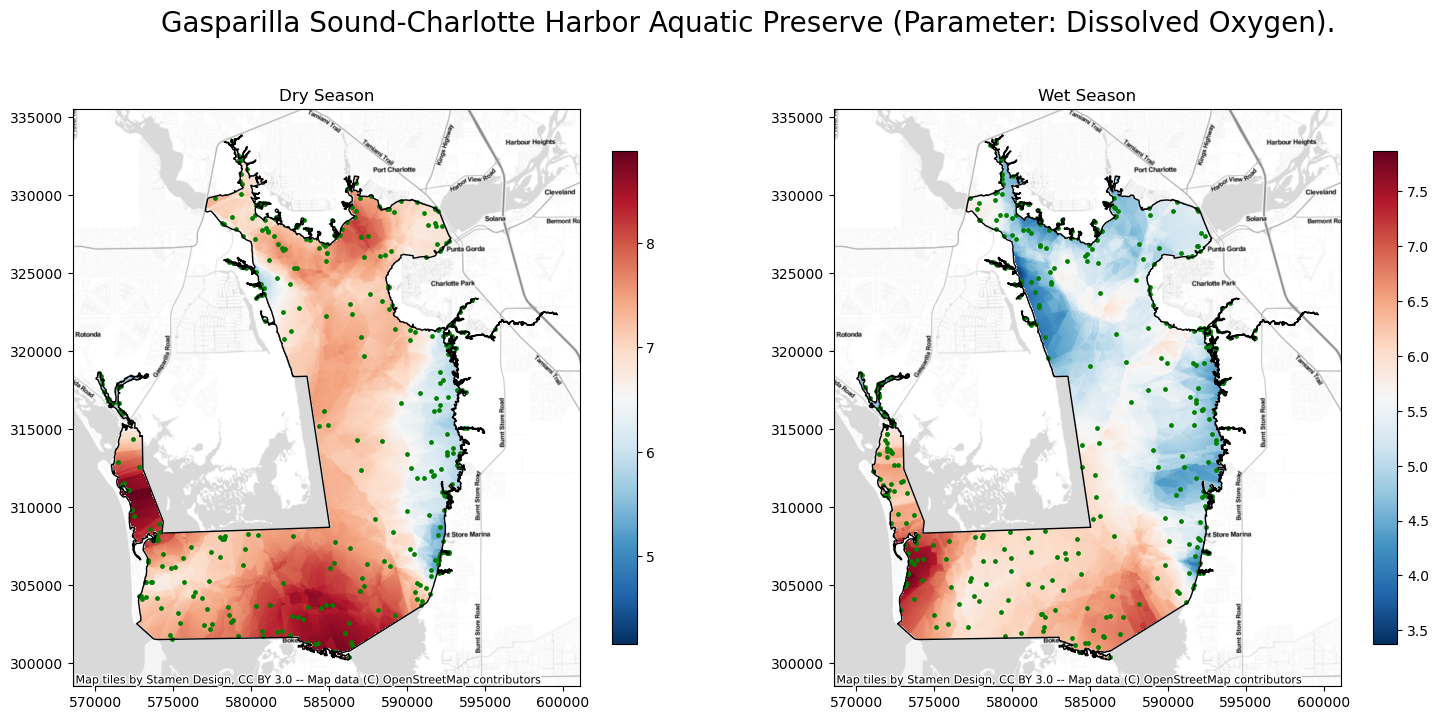

In [44]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

gdfDryShp.plot(ax = axes[0], marker = 'o', color = 'green', markersize = 6)
extentShp.plot(ax = axes[0], color='none', edgecolor='black')
cx.add_basemap(ax = axes[0],source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)

# Raster must added after basemap
with rasterio.open(gis_path + "dryKriging.tif", "r+") as dryOK:
    band = dryOK.read(1)
    band = numpy.ma.masked_array(band, mask=(band < 0))
    retted = rio_pl.show(band, transform=dryOK.transform, ax = axes[0], cmap="RdBu_r")
    axes[0].set_title('Dry Season')
    # Add legend
    im = retted.get_images()[1]
    fig.colorbar(im, ax=axes[0],shrink=0.8)


gdfWetShp.plot(ax = axes[1], marker = 'o', color = 'green', markersize = 6)
extentShp.plot(ax = axes[1], color='none', edgecolor='black')
cx.add_basemap(ax = axes[1],source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)

# Raster must added after basemap
with rasterio.open(gis_path + "wetKriging2.tif", "r+") as dryOK:
    band = dryOK.read(1)
    band = numpy.ma.masked_array(band, mask=(band < 0))
    retted = rio_pl.show(band, transform=dryOK.transform, ax = axes[1], cmap="RdBu_r")
    axes[1].set_title('Wet Season')
    # Add legend
    im = retted.get_images()[1]
    fig.colorbar(im, ax=axes[1],shrink=0.8)


### An altnerative way to visualize raster

In [ ]:
# fig, ax5 , cbar1 = idw.show_map(
#     input_raster=gis_path + 'wetKriging.tif',
#     colormap="coolwarm",
#     image_size=1.5,
#     return_figure=True)
# ax6.set_title("Wet Season Interpolation in 2019 (OK) ")
# ax6.set_xlabel("Longitude")
# ax6.set_ylabel("Latitude")
# gdfDryShp.plot(ax = ax5, marker = 'o', color = 'green', markersize = 6)
# extentShp.plot(ax = ax5, color='none', edgecolor='black')

# cbar1.set_label(Para)

# fig, ax6 , cbar1 = idw.show_map(
#     input_raster=gis_path + 'wetKriging.tif',
#     colormap="coolwarm",
#     image_size=1.5,
#     return_figure=True)
# ax6.set_title("Wet Season Interpolation in 2019 (OK) ")
# ax6.set_xlabel("Longitude")
# ax6.set_ylabel("Latitude")
# gdfDryShp.plot(ax = ax6, marker = 'o', color = 'green', markersize = 6)
# extentShp.plot(ax = ax6, color='none', edgecolor='black')

# cbar1.set_label(Para)
# #cx.add_basemap(ax=ax6,source=cx.providers.Stamen.TonerLite,crs='EPSG:'+SpatialRef)


# Inverse Distance Weighting (IDW)

Run IDW for both wet and dry seasons

In [45]:
# with arcpy.EnvManager(extent = extent, mask = path+"GIS_data/ch.shp",outputCoordinateSystem = arcpy.SpatialReference(3086), cellSize = 30):
#     outIDW_dry = Idw(gis_path + "gdfDry.shp", "ResultValu")
#     outIDW_wet = Idw(gis_path + "gdfWet.shp", "ResultValu")
    
#     outIDW_dry.save(gis_path + 'dryIDW.tif')
#     outIDW_wet.save(gis_path + 'wetIDW.tif')

In [82]:
with arcpy.EnvManager(extent=extent, mask = path+"GIS_data/ch.shp",outputCoordinateSystem = arcpy.SpatialReference(3086), cellSize = 30):
    arcpy.ga.IDW(in_features = gis_path + "gdfDry.shp", 
                 z_field = "ResultValu", 
#                This layer is not generated  
                 out_ga_layer = gis_path + "dryIDW.lyrx",
                 out_raster   = gis_path + "dryIDW.tif"
                )

with arcpy.EnvManager(extent=extent, mask = path+"GIS_data/ch.shp",outputCoordinateSystem = arcpy.SpatialReference(3086), cellSize = 30):
    arcpy.ga.IDW(in_features = gis_path + "gdfWet.shp", 
                 z_field = "ResultValu", 
#                This layer is not generated  
                 out_ga_layer = gis_path + "wetIDW.lyrx",
                 out_raster   = gis_path + "wetIDW.tif"
                )

Visualize the interpolated maps

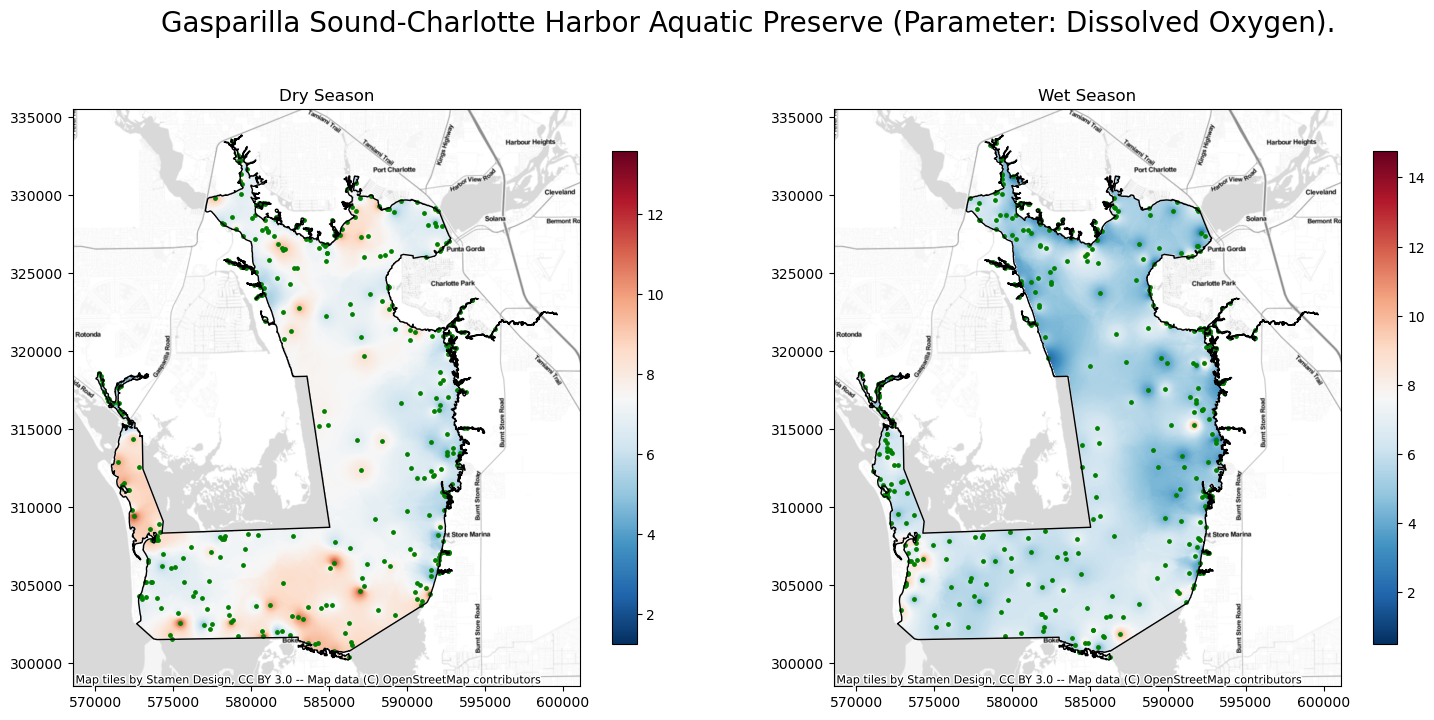

In [57]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

gdfDryShp.plot(ax = axes[0], marker = 'o', color = 'green', markersize = 6)
extentShp.plot(ax = axes[0], color='none', edgecolor='black')
cx.add_basemap(ax = axes[0],source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)

# Raster must added after basemap
with rasterio.open(gis_path + "dryIDW.tif", "r+") as dryOK:
    band = dryOK.read(1)
    band = numpy.ma.masked_array(band, mask=(band < 0))
    retted = rio_pl.show(band, transform=dryOK.transform, ax = axes[0], cmap="RdBu_r")
    axes[0].set_title('Dry Season')
    # Add legend
    im = retted.get_images()[1]
    fig.colorbar(im, ax=axes[0],shrink=0.8)


gdfWetShp.plot(ax = axes[1], marker = 'o', color = 'green', markersize = 6)
extentShp.plot(ax = axes[1], color='none', edgecolor='black')
cx.add_basemap(ax = axes[1],source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)

# Raster must added after basemap
with rasterio.open(gis_path + "wetIDW.tif", "r+") as dryOK:
    band = dryOK.read(1)
    band = numpy.ma.masked_array(band, mask=(band < 0))
    retted = rio_pl.show(band, transform=dryOK.transform, ax = axes[1], cmap="RdBu_r")
    axes[1].set_title('Wet Season')
    # Add legend
    im = retted.get_images()[1]
    fig.colorbar(im, ax=axes[1],shrink=0.8)

# Empirical Bayesian Kriging (EBK)

Run EBK for wet and dry seasons

In [53]:
start_time = time.time()

with arcpy.EnvManager(extent = extent, mask = path+"GIS_data/ch.shp",outputCoordinateSystem = arcpy.SpatialReference(3086), 
                      cellSize = 30, parallelProcessingFactor = "80%"):
    arcpy.ga.EmpiricalBayesianKriging(in_features = gis_path + 'gdfDry.shp', 
                                      z_field = "ResultValu", 
                                    # This layer is not generated  
                                      out_ga_layer = gis_path+"EBK_Dry_Layer",
                                      out_raster   = gis_path+"dryEBK.tif",
                                     # transformation_type = 'EMPIRICAL',
                                    search_neighborhood = arcpy.SearchNeighborhoodSmoothCircular(10000,0.5))
    
    arcpy.ga.EmpiricalBayesianKriging(in_features = gis_path + 'gdfWet.shp', 
                                      z_field = "ResultValu", 
                                     # This layer is not generated  
                                      out_ga_layer = gis_path+"EBK_Dry_Layer",
                                      out_raster = gis_path+"wetEBK.tif",
                                     # transformation_type = 'EMPIRICAL',
                                    search_neighborhood = arcpy.SearchNeighborhoodSmoothCircular(10000,0.5))
    
print("--- Time lapse: %s seconds ---" % (time.time() - start_time))

--- Time lapse: 574.4709351062775 seconds ---


Visualize the interpolated maps

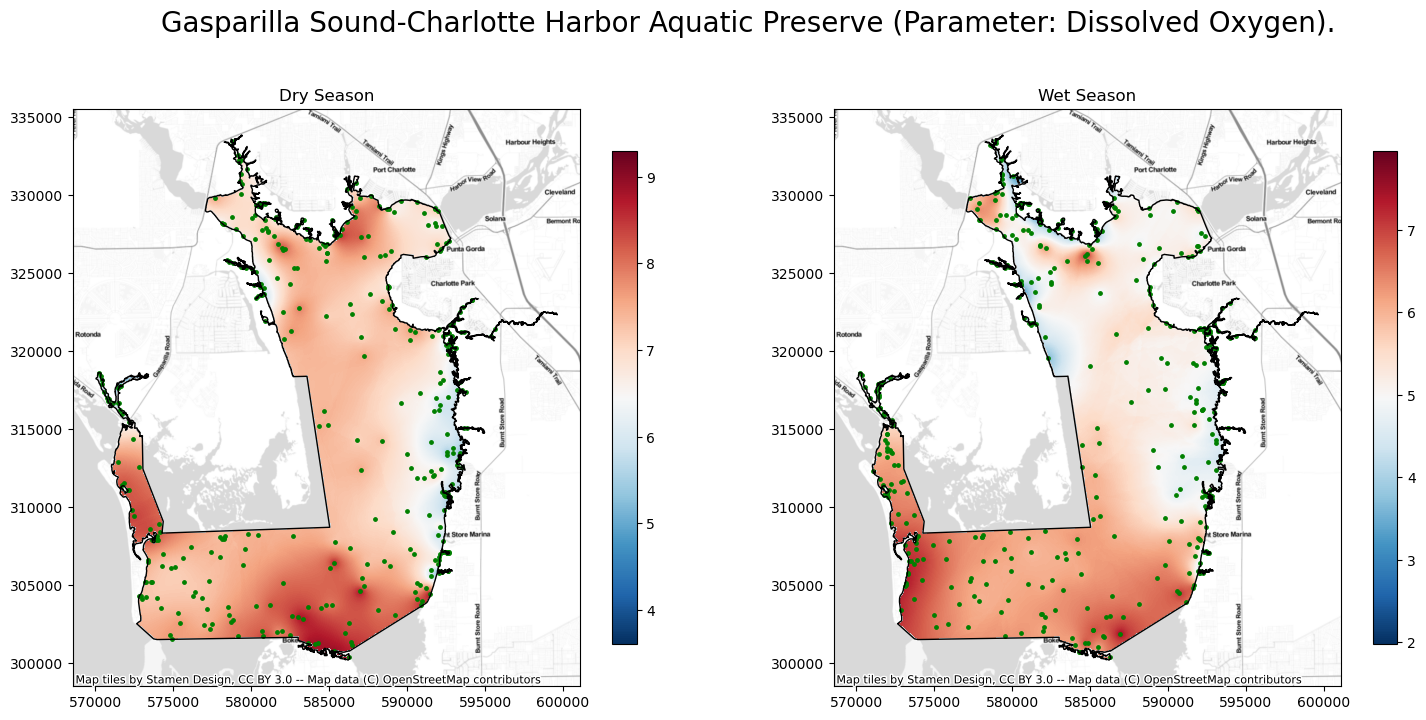

In [54]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

gdfDryShp.plot(ax = axes[0], marker = 'o', color = 'green', markersize = 6)
extentShp.plot(ax = axes[0], color='none', edgecolor='black')
cx.add_basemap(ax = axes[0],source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)

# Raster must added after basemap
with rasterio.open(gis_path + "dryEBK.tif", "r+") as dryOK:
    band = dryOK.read(1)
    band = numpy.ma.masked_array(band, mask=(band < 0))
    retted = rio_pl.show(band, transform=dryOK.transform, ax = axes[0], cmap="RdBu_r")
    axes[0].set_title('Dry Season')
    # Add legend
    im = retted.get_images()[1]
    fig.colorbar(im, ax=axes[0],shrink=0.8)


gdfWetShp.plot(ax = axes[1], marker = 'o', color = 'green', markersize = 6)
extentShp.plot(ax = axes[1], color='none', edgecolor='black')
cx.add_basemap(ax = axes[1],source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)

# Raster must added after basemap
with rasterio.open(gis_path + "wetEBK.tif", "r+") as dryOK:
    band = dryOK.read(1)
    band = numpy.ma.masked_array(band, mask=(band < 0))
    retted = rio_pl.show(band, transform=dryOK.transform, ax = axes[1], cmap="RdBu_r")
    axes[1].set_title('Wet Season')
    # Add legend
    im = retted.get_images()[1]
    fig.colorbar(im, ax=axes[1],shrink=0.8)


## Regression Kriging (RK)

### Clip covariate rasters

Read the table of managed areas

In [122]:
ma_table = pd.read_csv(gis_path + "MA_table.csv")
ra_fname = 'basy_{}.tif'.format(ma_table[ma_table['LONG_NAME']== Area]['MA_AreaID'].iloc[0].astype(str))

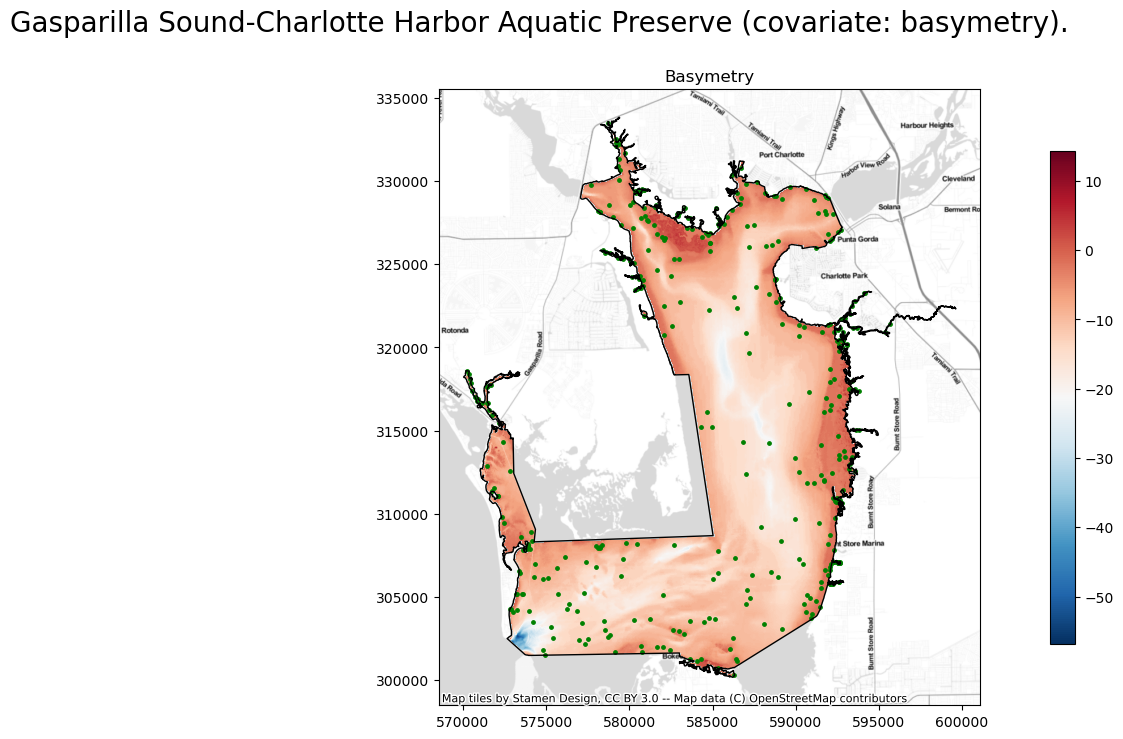

In [123]:
fig, ax = plt.subplots(1, figsize=(18, 8))

fig.suptitle("{} (covariate: {}).".format(Area, 'basymetry'),fontsize=20)

gdfDryShp.plot(ax = ax, marker = 'o', color = 'green', markersize = 6)
extentShp.plot(ax = ax, color='none', edgecolor='black')
cx.add_basemap(ax = ax,source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)

# Raster must added after basemap
with rasterio.open(gis_path + "covariates/basymetry/basy_18.tif", "r+") as covar:
    band = covar.read(1)
    #band = numpy.ma.masked_array(band, mask=(band < -1000))
    #band = numpy.ma.masked_array(band, mask=(band > 1000))
    band = np.ma.masked_where((band < -100) | (band > 100), band)
    retted = rio_pl.show(band, transform=covar.transform, ax = ax, cmap="RdBu_r")
    ax.set_title('Basymetry')
    # Add legend
    im = retted.get_images()[1]
    fig.colorbar(im, ax=ax,shrink=0.8)


EBK Regression Prediction in ArcGIS.

In [126]:
start_time = time.time()

with arcpy.EnvManager(extent = extent, mask = path+"GIS_data/ch.shp",outputCoordinateSystem = arcpy.SpatialReference(3086), 
                      cellSize = 30, parallelProcessingFactor = "80%"):
    out_surface_raster = arcpy.EBKRegressionPrediction_ga(in_features = gis_path + "gdfDry.shp", 
                                                           dependent_field = "ResultValu", 
                                                          out_ga_layer = gis_path + "dryRK_GA",
                                                            out_raster = gis_path + "dryRK.tif",
                                                          in_explanatory_rasters = gis_path + "covariates/{}".format('NCEI_DEM_30m.tif'),
                                                           transformation_type = 'EMPIRICAL',
                                                          search_neighborhood = arcpy.SearchNeighborhoodSmoothCircular(10000,0.5)) 
    
    out_surface_raster = arcpy.EBKRegressionPrediction_ga(in_features = gis_path + "gdfWet.shp", 
                                                           dependent_field = "ResultValu",
                                                          out_ga_layer = gis_path + "wetRK_GA",
                                                          out_raster = gis_path + "wetRK.tif",
                                                          in_explanatory_rasters = gis_path + "covariates/{}".format('NCEI_DEM_30m.tif'),
                                                           transformation_type = 'EMPIRICAL',
                                                          search_neighborhood = arcpy.SearchNeighborhoodSmoothCircular(10000,0.5))
    
print("--- Time lapse: %s seconds ---" % (time.time() - start_time))

--- Time lapse: 870.0750789642334 seconds ---


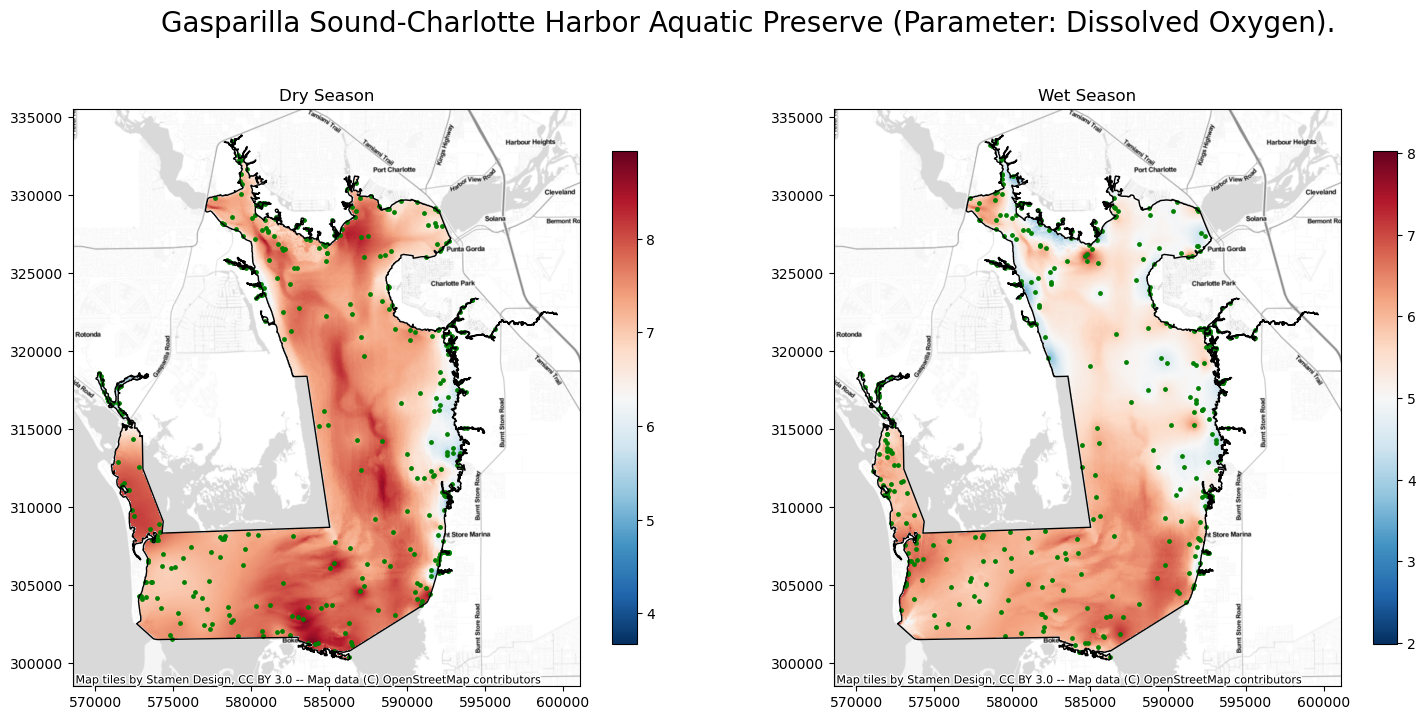

In [128]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

gdfDryShp.plot(ax = axes[0], marker = 'o', color = 'green', markersize = 6)
extentShp.plot(ax = axes[0], color='none', edgecolor='black')
cx.add_basemap(ax = axes[0],source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)

# Raster must added after basemap
with rasterio.open(gis_path + "dryRK.tif", "r+") as dryOK:
    band = dryOK.read(1)
    band = numpy.ma.masked_array(band, mask=(band < 0))
    retted = rio_pl.show(band, transform=dryOK.transform, ax = axes[0], cmap="RdBu_r")
    axes[0].set_title('Dry Season')
    # Add legend
    im = retted.get_images()[1]
    fig.colorbar(im, ax=axes[0],shrink=0.8)


gdfWetShp.plot(ax = axes[1], marker = 'o', color = 'green', markersize = 6)
extentShp.plot(ax = axes[1], color='none', edgecolor='black')
cx.add_basemap(ax = axes[1],source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)

# Raster must added after basemap
with rasterio.open(gis_path + "wetRK.tif", "r+") as dryOK:
    band = dryOK.read(1)
    band = numpy.ma.masked_array(band, mask=(band < 0))
    retted = rio_pl.show(band, transform=dryOK.transform, ax = axes[1], cmap="RdBu_r")
    axes[1].set_title('Wet Season')
    # Add legend
    im = retted.get_images()[1]
    fig.colorbar(im, ax=axes[1],shrink=0.8)

# Result Assessment

## Original Kriging

In [139]:
crossv_Dry_OK = gpd.read_file(gis_path + "dryOK_crossv.shp")
crossv_Wet_OK = gpd.read_file(gis_path + "wetOK_crossv.shp")

In [150]:
dryOKStat = pd.DataFrame(crossv_Dry_OK["Error"].agg(["sum","max","min","std","mean"])).reset_index()
wetOKStat = pd.DataFrame(crossv_Wet_OK["Error"].agg(["sum","max","min","std","mean"])).reset_index()

In [154]:
dryOKStat = dryOKStat.rename(columns={"index":"Statistic Type","Error":"Original Kriging"})
wetOKStat = wetOKStat.rename(columns={"index":"Statistic Type","Error":"Original Kriging"})

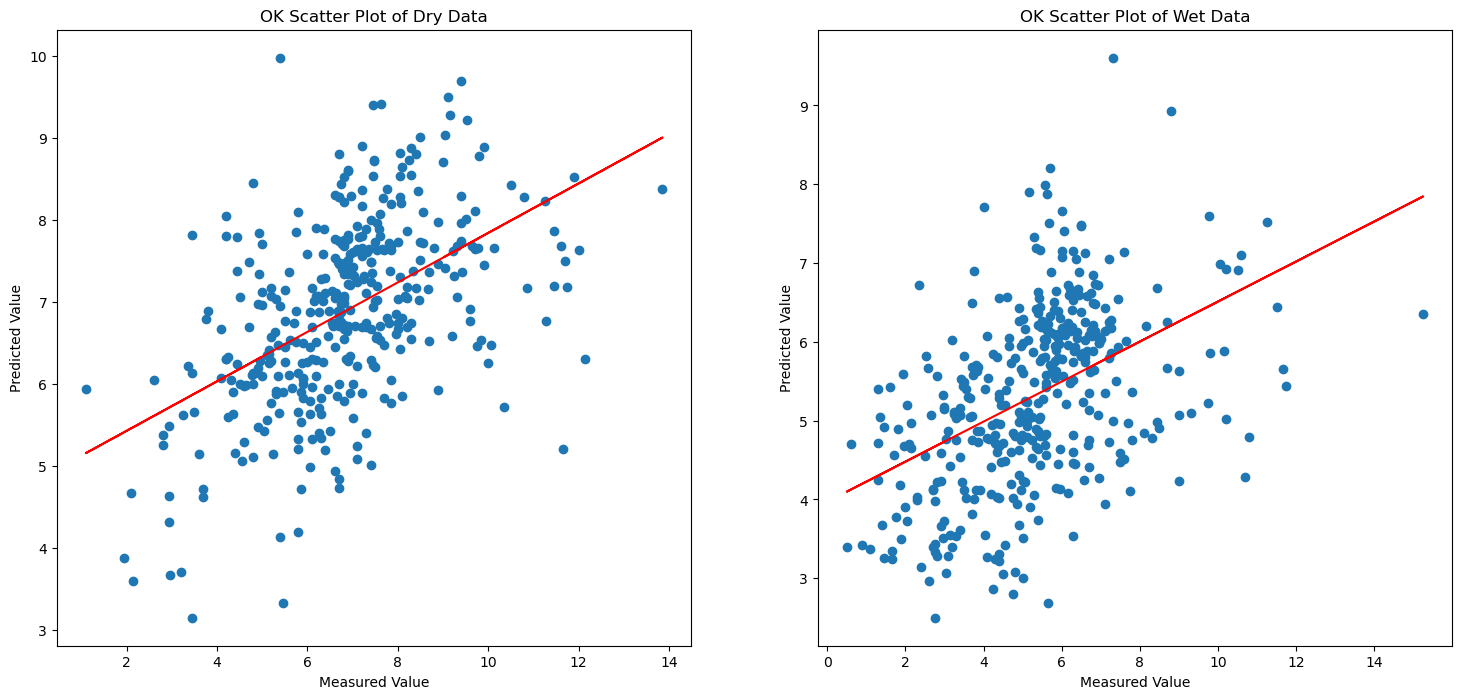

In [163]:
plt.subplots(1,2, figsize=(18, 8))

plt.subplot(121)
x=crossv_Dry_OK["Measured"]
y=crossv_Dry_OK["Predicted"]

plt.scatter(x,y)
plt.xlabel("Measured Value")
plt.ylabel("Predicted Value")
plt.title("OK Scatter Plot of Dry Data")

z = np.polyfit(x, y, 1)
p = np.poly1d(z)

plt.plot(x, p(x),color="red")

plt.subplot(122)
x=crossv_Wet_OK["Measured"]
y=crossv_Wet_OK["Predicted"]

plt.scatter(x,y)
plt.xlabel("Measured Value")
plt.ylabel("Predicted Value")
plt.title("OK Scatter Plot of Wet Data")

z = np.polyfit(x, y, 1)
p = np.poly1d(z)

plt.plot(x, p(x),color="red")

## Inverse Distance Weighting (IDW)

In [129]:
crossv_Dry_IDW = gpd.read_file(gis_path + "dryIDW_crossv.shp")
crossv_Wet_IDW = gpd.read_file(gis_path + "wetIDW_crossv.shp")

In [158]:
dryIDWStat = pd.DataFrame(crossv_Dry_IDW["Error"].agg(["sum","max","min","std","mean"])).reset_index()
wetIDWStat = pd.DataFrame(crossv_Wet_IDW["Error"].agg(["sum","max","min","std","mean"])).reset_index()

In [159]:
dryIDWStat = dryIDWStat.rename(columns={"index":"Statistic Type","Error":"Inverse Distance Weighting"})
wetIDWStat = wetIDWStat.rename(columns={"index":"Statistic Type","Error":"Inverse Distance Weighting"})

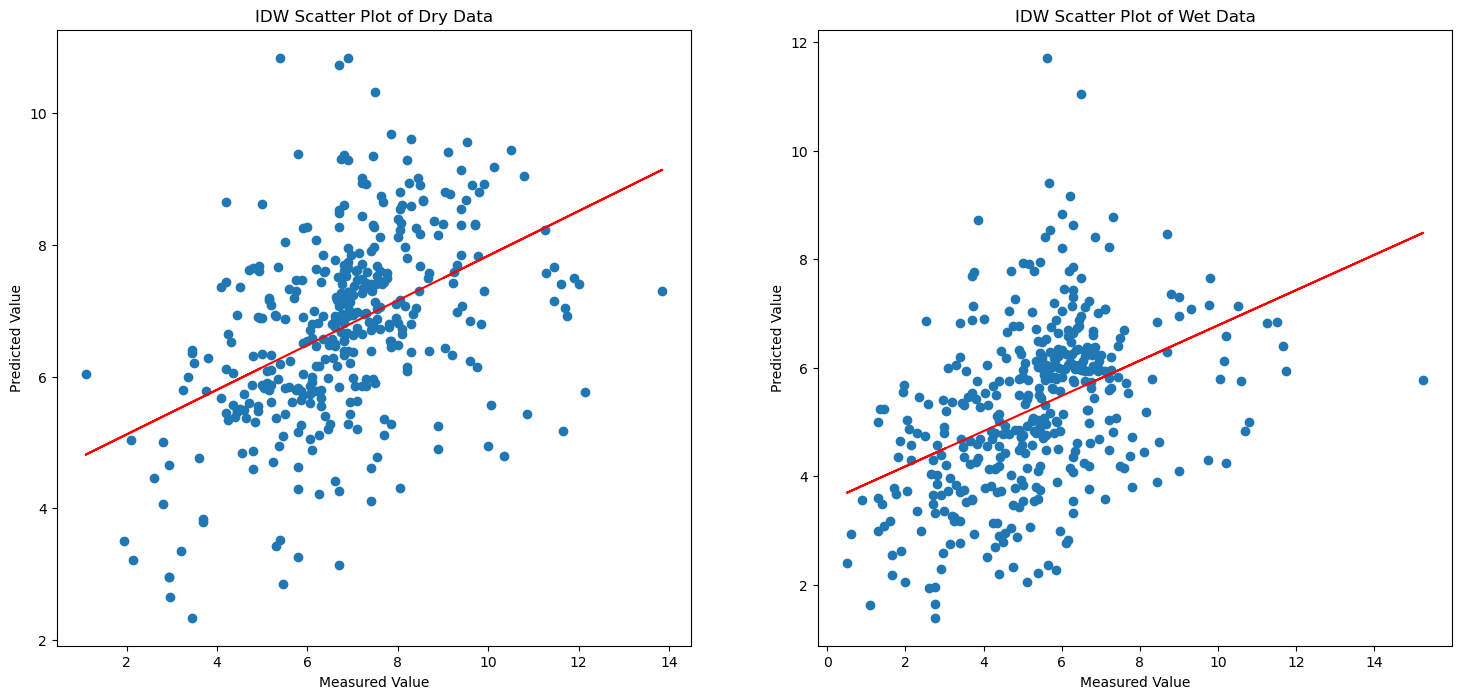

In [164]:
plt.subplots(1,2, figsize=(18, 8))

plt.subplot(121)
x=crossv_Dry_IDW["Measured"]
y=crossv_Dry_IDW["Predicted"]

plt.scatter(x,y)
plt.xlabel("Measured Value")
plt.ylabel("Predicted Value")
plt.title("IDW Scatter Plot of Dry Data")

z = np.polyfit(x, y, 1)
p = np.poly1d(z)

plt.plot(x, p(x),color="red")

plt.subplot(122)
x=crossv_Wet_IDW["Measured"]
y=crossv_Wet_IDW["Predicted"]

plt.scatter(x,y)
plt.xlabel("Measured Value")
plt.ylabel("Predicted Value")
plt.title("IDW Scatter Plot of Wet Data")

z = np.polyfit(x, y, 1)
p = np.poly1d(z)

plt.plot(x, p(x),color="red")

## Empirical Bayesian Kriging (EBK)

In [160]:
crossv_Dry_EBK = gpd.read_file(gis_path + "dryEBK_crossv.shp")
crossv_Wet_EBK = gpd.read_file(gis_path + "wetEBK_crossv.shp")

In [161]:
dryEBKStat = pd.DataFrame(crossv_Dry_EBK["Error"].agg(["sum","max","min","std","mean"])).reset_index()
wetEBKStat = pd.DataFrame(crossv_Wet_EBK["Error"].agg(["sum","max","min","std","mean"])).reset_index()

In [162]:
dryEBKStat = dryEBKStat.rename(columns={"index":"Statistic Type","Error":"Empirical Bayesian Kriging"})
wetEBKStat = wetEBKStat.rename(columns={"index":"Statistic Type","Error":"Empirical Bayesian Kriging"})

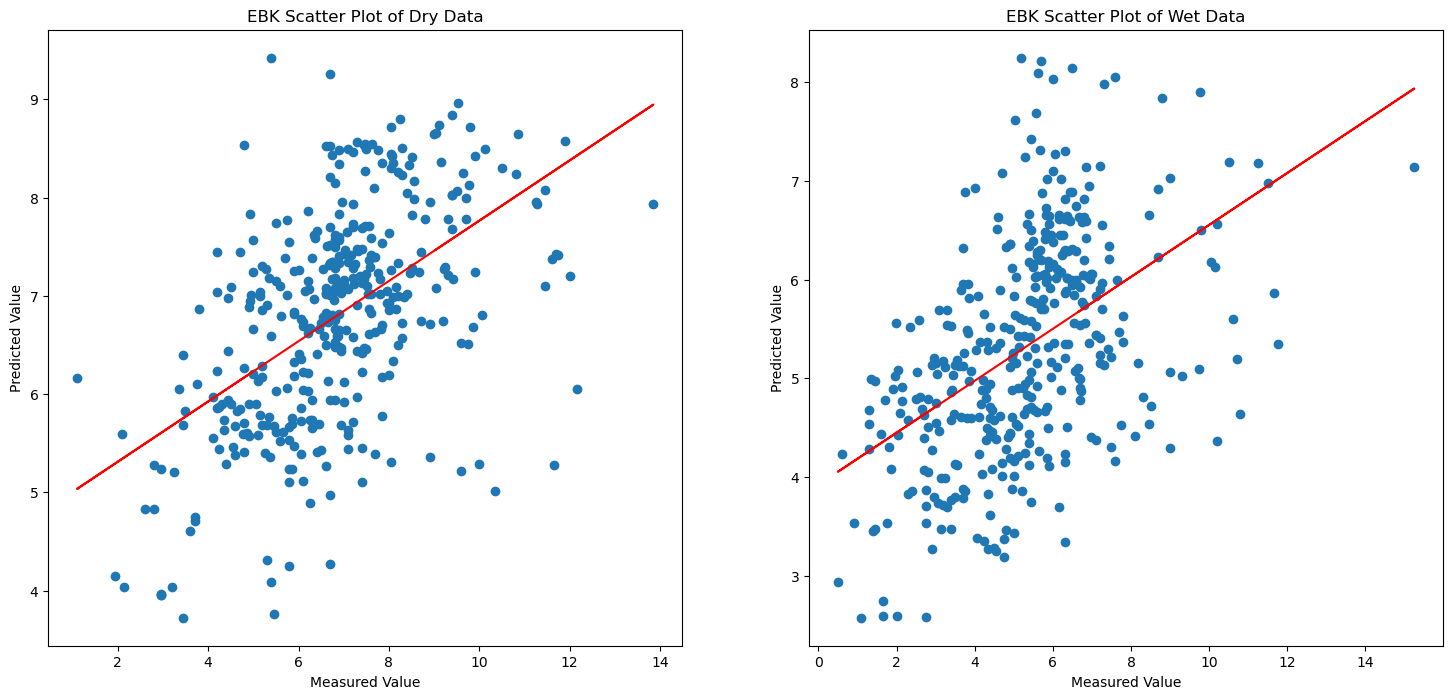

In [116]:
plt.subplots(1,2, figsize=(18, 8))

plt.subplot(121)
x=crossv_Dry_EBK["Measured"]
y=crossv_Dry_EBK["Predicted"]

plt.scatter(x,y)
plt.xlabel("Measured Value")
plt.ylabel("Predicted Value")
plt.title("EBK Scatter Plot of Dry Data")

z = np.polyfit(x, y, 1)
p = np.poly1d(z)

plt.plot(x, p(x),color="red")

plt.subplot(122)
x=crossv_Wet_EBK["Measured"]
y=crossv_Wet_EBK["Predicted"]

plt.scatter(x,y)
plt.xlabel("Measured Value")
plt.ylabel("Predicted Value")
plt.title("EBK Scatter Plot of Wet Data")

z = np.polyfit(x, y, 1)
p = np.poly1d(z)

plt.plot(x, p(x),color="red")

Text(0.5, 1.0, 'Wet Season')

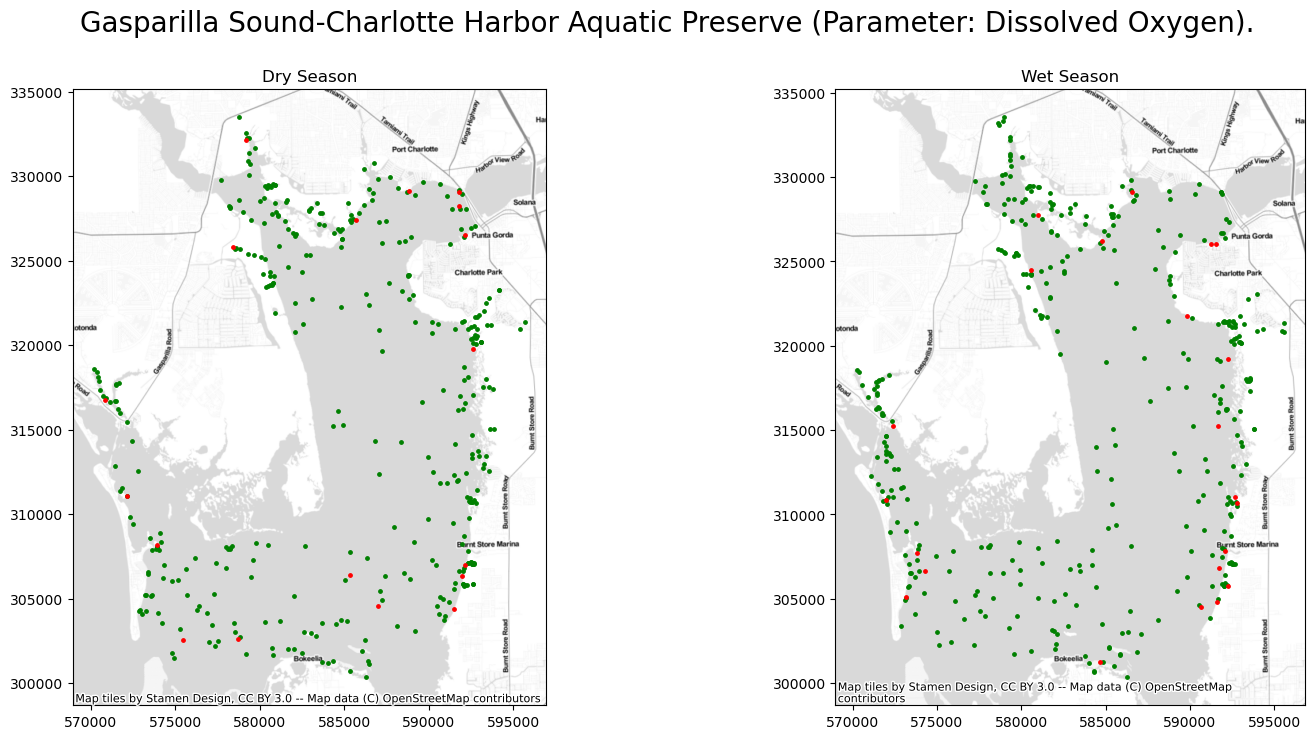

In [132]:
noInterval95DryEBK  = crossv_Dry_EBK[crossv_Dry_EBK["Interval95"]=="No"]
yesInterval95DryEBK = crossv_Dry_EBK[crossv_Dry_EBK["Interval95"]=="Yes"]
noInterval95WetEBK  = crossv_Wet_EBK[crossv_Wet_EBK["Interval95"]=="No"]
yesInterval95WetEBK = crossv_Wet_EBK[crossv_Wet_EBK["Interval95"]=="Yes"]

fig, axes = plt.subplots(1,2, figsize=(18, 8))
fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

yesInterval95DryEBK.plot(ax = axes[0], marker = 'o', color = 'green', markersize = 6)
noInterval95DryEBK.plot(ax = axes[0], marker = 'o', color = 'red', markersize = 6)
# extentShp.plot(ax = axes[0], color='none', edgecolor='black')
cx.add_basemap(ax = axes[0],source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)
axes[0].set_title('Dry Season')

yesInterval95WetEBK.plot(ax = axes[1], marker = 'o', color = 'green', markersize = 6)
noInterval95WetEBK.plot(ax = axes[1], marker = 'o', color = 'red', markersize = 6)
# extentShp.plot(ax = axes[1], color='none', edgecolor='black')
cx.add_basemap(ax = axes[1],source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)
axes[1].set_title('Wet Season')

## Regression Kriging (RK)

In [184]:
crossv_Dry_RK = gpd.read_file(gis_path + "dryRK_crossv.shp")
crossv_Wet_RK = gpd.read_file(gis_path + "wetRK_crossv.shp")

In [185]:
dryRKStat = pd.DataFrame(crossv_Dry_RK["Error"].agg(["sum","max","min","std","mean"])).reset_index()
wetRKStat = pd.DataFrame(crossv_Wet_RK["Error"].agg(["sum","max","min","std","mean"])).reset_index()

In [186]:
dryRKStat = dryRKStat.rename(columns={"index":"Statistic Type","Error":"Regression Kriging"})
wetRKStat = wetRKStat.rename(columns={"index":"Statistic Type","Error":"Regression Kriging"})

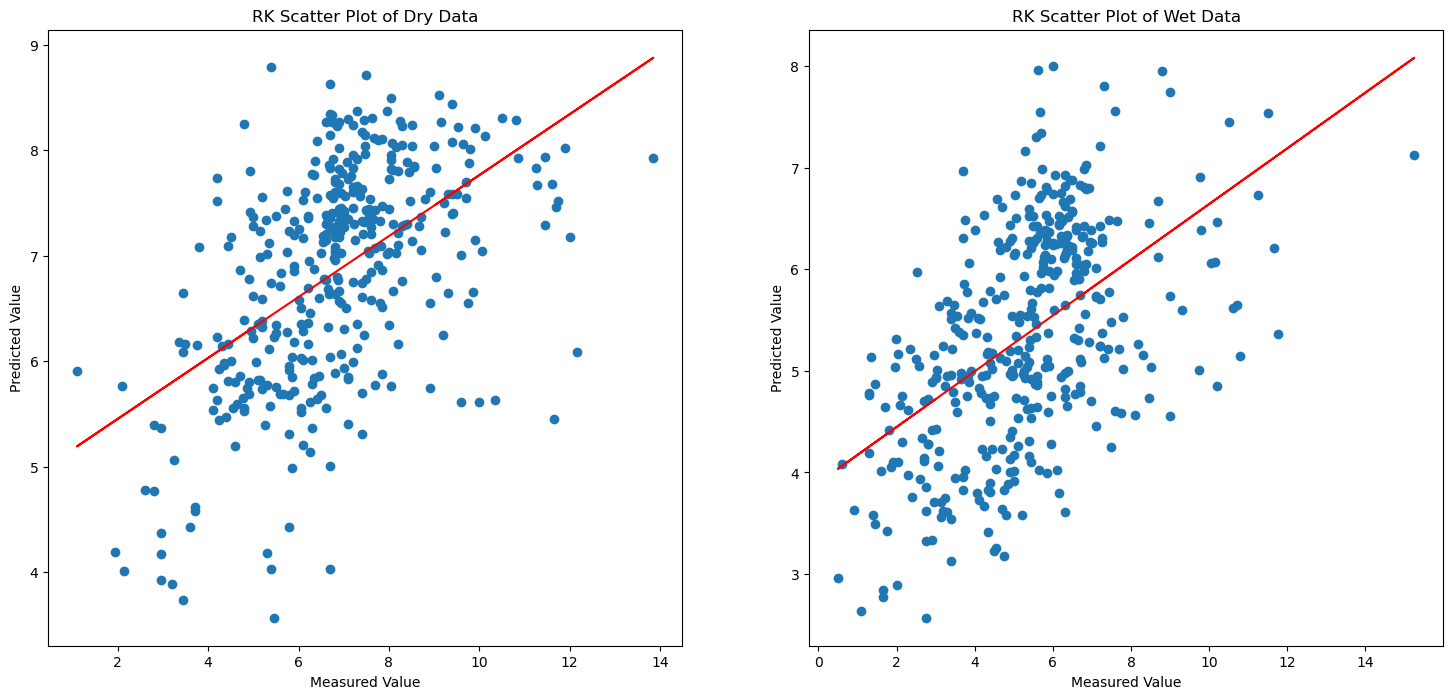

In [170]:
plt.subplots(1,2, figsize=(18, 8))

plt.subplot(121)
x=crossv_Dry_RK["Measured"]
y=crossv_Dry_RK["Predicted"]

plt.scatter(x,y)
plt.xlabel("Measured Value")
plt.ylabel("Predicted Value")
plt.title("RK Scatter Plot of Dry Data")

z = np.polyfit(x, y, 1)
p = np.poly1d(z)

plt.plot(x, p(x),color="red")

plt.subplot(122)
x=crossv_Wet_RK["Measured"]
y=crossv_Wet_RK["Predicted"]

plt.scatter(x,y)
plt.xlabel("Measured Value")
plt.ylabel("Predicted Value")
plt.title("RK Scatter Plot of Wet Data")

z = np.polyfit(x, y, 1)
p = np.poly1d(z)

plt.plot(x, p(x),color="red")

Text(0.5, 1.0, 'Wet Season')

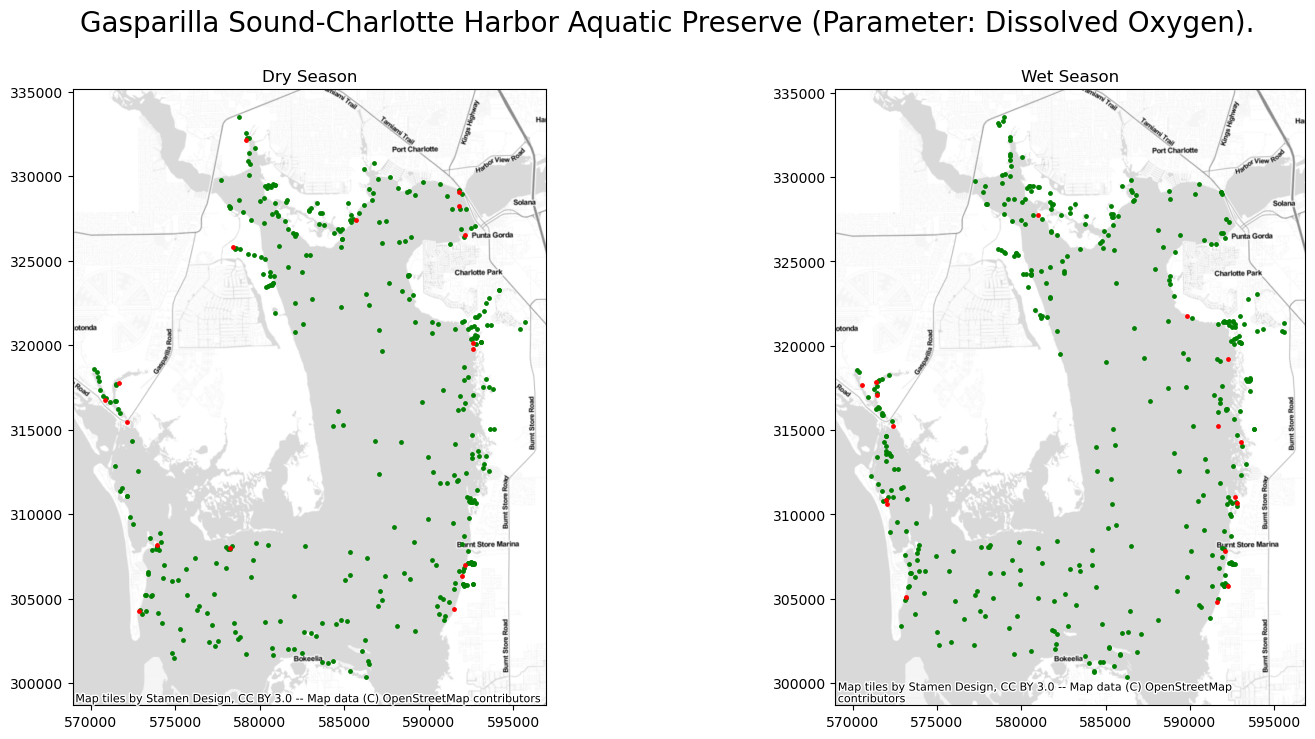

In [171]:
noInterval95DryRK  = crossv_Dry_RK[crossv_Dry_RK["Interval95"]=="No"]
yesInterval95DryRK = crossv_Dry_RK[crossv_Dry_RK["Interval95"]=="Yes"]
noInterval95WetRK  = crossv_Wet_RK[crossv_Wet_RK["Interval95"]=="No"]
yesInterval95WetRK = crossv_Wet_RK[crossv_Wet_RK["Interval95"]=="Yes"]

fig, axes = plt.subplots(1,2, figsize=(18, 8))
fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

yesInterval95DryRK.plot(ax = axes[0], marker = 'o', color = 'green', markersize = 6)
noInterval95DryRK.plot(ax = axes[0], marker = 'o', color = 'red', markersize = 6)
# extentShp.plot(ax = axes[0], color='none', edgecolor='black')
cx.add_basemap(ax = axes[0],source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)
axes[0].set_title('Dry Season')

yesInterval95WetRK.plot(ax = axes[1], marker = 'o', color = 'green', markersize = 6)
noInterval95WetRK.plot(ax = axes[1], marker = 'o', color = 'red', markersize = 6)
# extentShp.plot(ax = axes[1], color='none', edgecolor='black')
cx.add_basemap(ax = axes[1],source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)
axes[1].set_title('Wet Season')

In [190]:
merged_df1 = pd.merge(dryOKStat , dryIDWStat, how="inner", left_on="Statistic Type", right_on="Statistic Type")
merged_df2 = pd.merge(dryEBKStat, dryRKStat , how="inner", left_on="Statistic Type", right_on="Statistic Type")
merged_dry = pd.merge(merged_df1, merged_df2, how="inner", left_on="Statistic Type", right_on="Statistic Type")

In [191]:
merged_dry

Statistic Type  Original Kriging  Inverse Distance Weighting  \
0            sum         21.460314                  -26.492359   
1            max          4.840240                    5.442601   
2            min         -6.443699                   -6.554997   
3            std          1.637329                    1.776005   
4           mean          0.055886                   -0.068991   

   Empirical Bayesian Kriging  Regression Kriging  
0                  -13.428274            7.264401  
1                    5.059993            4.804226  
2                   -6.371714           -6.198634  
3                    1.603957            1.600933  
4                   -0.034969            0.018918

In [192]:
merged_df3 = pd.merge(wetOKStat , wetIDWStat, how="inner", left_on="Statistic Type", right_on="Statistic Type")
merged_df4 = pd.merge(wetEBKStat, wetRKStat , how="inner", left_on="Statistic Type", right_on="Statistic Type")
merged_wet = pd.merge(merged_df3, merged_df4, how="inner", left_on="Statistic Type", right_on="Statistic Type")

In [193]:
merged_wet

Statistic Type  Original Kriging  Inverse Distance Weighting  \
0            sum          4.994726                  -19.460195   
1            max          4.376746                    6.091897   
2            min         -8.890744                   -9.469889   
3            std          1.833119                    1.977224   
4           mean          0.012581                   -0.049018   

   Empirical Bayesian Kriging  Regression Kriging  
0                    4.854009           18.496023  
1                    3.642037            3.787326  
2                   -8.108701           -8.125319  
3                    1.796319            1.748257  
4                    0.012227            0.046589